In [1]:
%matplotlib inline
import os
from argparse import ArgumentParser
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from helper import *

torch.cuda.set_device(0)

/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akshay/anaconda3/envs/pl/lib/py

In [4]:
class SegModel(pl.LightningModule):
    def __init__(self):
        super(SegModel, self).__init__()
        self.batch_size = 4
        self.learning_rate = 1e-3
        self.net = torchvision.models.segmentation.fcn_resnet50(pretrained = False, progress = True, num_classes = 19)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
        ])
        self.trainset = semantic_dataset(split = 'train', transform = self.transform)
        self.testset = semantic_dataset(split = 'test', transform = self.transform)
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_nb) :
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss_val = F.cross_entropy(out['out'], mask, ignore_index = 250)
#         print(loss.shape)
        return {'loss' : loss_val}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 10)
        return [opt], [sch]
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size = self.batch_size, shuffle = True)
    
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size = 1, shuffle = True)

In [5]:
model = SegModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath = 'checkpoints/',
    save_best_only = True,
    verbose = True, 
    monitor = 'loss',
    mode = 'min',
    prefix = ''
)
trainer = pl.Trainer(gpus = 1, max_nb_epochs = 15, checkpoint_callback = checkpoint_callback)
trainer.fit(model)

Epoch 3: 100%|██████████| 50/50 [02:13<00:00,  2.69s/batch, batch_nb=49, gpu=0, loss=0.201, v_nb=4]/home/akshay/anaconda3/envs/pl/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:128: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  RuntimeWarning)
Epoch 3: 100%|██████████| 50/50 [02:13<00:00,  2.68s/batch, batch_nb=49, gpu=0, loss=0.201, v_nb=4]


1

In [6]:
model = SegModel()
checkpoint = torch.load('checkpoints/_ckpt_epoch_3.ckpt', map_location = lambda storage, loc : storage)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

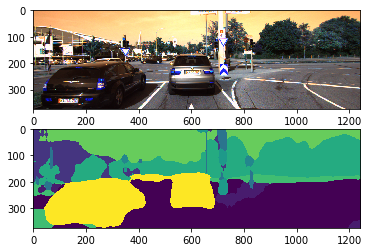

In [7]:
model.cuda()
testloader = model.test_dataloader()
img = next(iter(testloader)).float().cuda()
y = model.forward(img)
mask_pred = y['out'].cpu().detach().numpy()
mask_pred_bw = np.argmax(mask_pred[0], axis = 0)

unorm = UnNormalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
img2 = unorm(img)
img2 = img.transpose(1, 2).transpose(2, 3).detach().cpu().numpy()

fig, axes = plt.subplots(2, 1)
axes[0].imshow(img2[0])
axes[1].imshow(mask_pred_bw)
plt.savefig('output.png')
plt.show()